* **Louai Al Jabi**
* **DSA411**
* **Final Project**


(Revised 12/09/2023)

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

### Answering Q1-Can I build a model that predicts the likelyhood a person would develop diabetes

#### Read the Data

In [2]:
diabetes = pd.read_csv('Diabetes.csv')

In [3]:
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 529 entries, 0 to 528
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0.1      529 non-null    int64  
 1   Unnamed: 0        529 non-null    int64  
 2   Age               529 non-null    object 
 3   Gender            529 non-null    object 
 4   Family_Diabetes   529 non-null    object 
 5   highBP            529 non-null    object 
 6   PhysicallyActive  529 non-null    object 
 7   BMI               529 non-null    float64
 8   Smoking           529 non-null    object 
 9   Alcohol           529 non-null    object 
 10  Sleep             529 non-null    int64  
 11  SoundSleep        529 non-null    int64  
 12  RegularMedicine   529 non-null    object 
 13  JunkFood          529 non-null    object 
 14  Stress            529 non-null    object 
 15  BPLevel           529 non-null    object 
 16  Pregnancies       529 non-null    float64
 1

In [4]:
diabetes.describe(include = ['object'])

,Age,Gender,Family_Diabetes,highBP,PhysicallyActive,Smoking,Alcohol,RegularMedicine,JunkFood,Stress,BPLevel,Pdiabetes,UrinationFreq,Diabetic
count,529,529,529,529,529,529,529,529,529,529,529,529,529,529
unique,4,2,2,2,4,2,2,2,4,4,5,2,2,2
top,less than 40,Male,yes,no,less than half an hr,no,no,no,occasionally,sometimes,normal,no,not much,no
freq,209,319,275,363,174,474,426,272,374,282,351,516,372,265


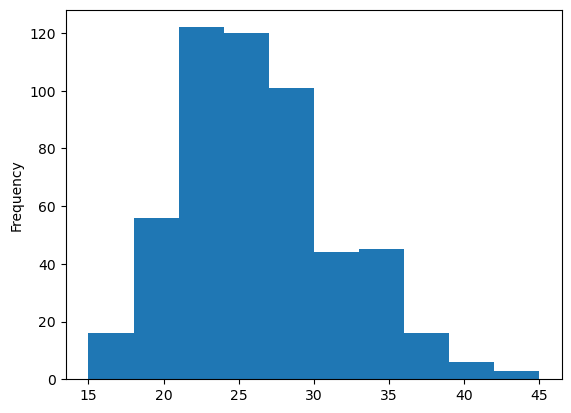

In [5]:
diabetes['BMI'].plot(kind = 'hist');

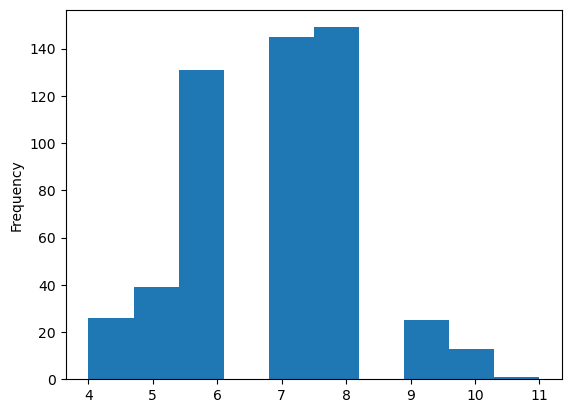

In [6]:
diabetes['Sleep'].plot(kind = 'hist');

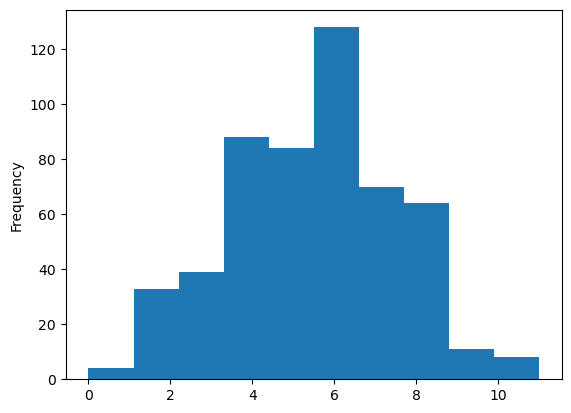

In [7]:
diabetes['SoundSleep'].plot(kind = 'hist');

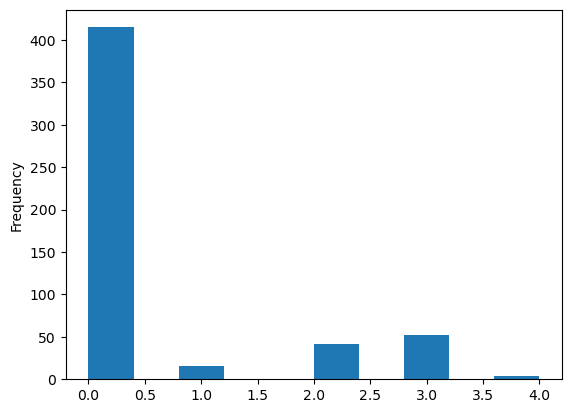

In [8]:
diabetes['Pregnancies'].plot(kind = 'hist');

In [9]:
diabetes['Diabetic'].value_counts()

no     265
yes    264
Name: Diabetic, dtype: int64

### Divide data into features and target

In [10]:
# get all columns apart from Diabetic for the features
features = diabetes.drop('Diabetic', axis=1)

# split dataframe into train and test. Use smaller test portion since small dataset
X_train, X_test, y_train, y_test = train_test_split(
    features, diabetes['Diabetic'], random_state=7, 
    stratify = diabetes['Diabetic'],
    test_size = 0.20)

In [11]:
X_train.shape

(423, 19)

In [12]:
y_train.shape

(423,)

In [13]:
X_test.shape

(106, 19)

In [14]:
y_test.shape

(106,)

#### Use comprehensions to get lists of column names

In [15]:
[col for col in diabetes.dtypes.index if diabetes[col].dtype == 'object']

['Age',
 'Gender',
 'Family_Diabetes',
 'highBP',
 'PhysicallyActive',
 'Smoking',
 'Alcohol',
 'RegularMedicine',
 'JunkFood',
 'Stress',
 'BPLevel',
 'Pdiabetes',
 'UrinationFreq',
 'Diabetic']

In [16]:
[col for col in diabetes.dtypes.index if diabetes[col].dtype in ['float64', 'int64']]

['Unnamed: 0.1', 'Unnamed: 0', 'BMI', 'Sleep', 'SoundSleep', 'Pregnancies']

### Set up analysis pipeline
* Using classification to predict a class output with logistic regression and SVC
* Apply a StandardScaler to the numerical values, and OneHotEncoder to the catagorical values.

In [17]:
# Column transformer, StandardScaler, OneHotEncoder
ct_std_ohe = make_column_transformer(
    (StandardScaler(), ['BMI', 'Sleep', 'SoundSleep', 'Pregnancies']),
    
    (OneHotEncoder(handle_unknown = 'ignore'), 
     ['Age', 'Gender', 'Family_Diabetes', 'highBP', 'PhysicallyActive',
      'Smoking', 'Alcohol', 'RegularMedicine', 'JunkFood', 'Stress',
      'BPLevel', 'Pdiabetes', 'UrinationFreq']))


#### Next, set up pipeline
* Use LogisticRegression as placeholder for the column transformer and estimator function

In [18]:
pipe = Pipeline([('preprocessing', ct_std_ohe),
                  ('classifier', LogisticRegression(max_iter = 1000))]) #Place Holder

In [19]:
# Set param grid for GridSearch
param_grid = [
    {'preprocessing': [ct_std_ohe],
     'classifier__C': np.logspace(-5, 4, 10)}, # logistic regression, C
    
    {'classifier':[SVC(probability=True)],
     'preprocessing': [ct_std_ohe],
     'classifier__C': [0.001,0.01,0.1,1,5,10,100],
     'classifier__gamma':[0.5,1,2,3,4],
     'classifier__kernel':['linear','poly', 'rbf']}, # SVC    
    ]

* Now, Gridsearch and get best score and parameters

In [53]:
strat_kfold = StratifiedKFold(5, shuffle = True) #stratified because I have a small dataset
gs = GridSearchCV(pipe, param_grid, cv = strat_kfold, refit = True, scoring = 'roc_auc', verbose = 1)

In [54]:
gs.fit(X_train, y_train)

Fitting 5 folds for each of 115 candidates, totalling 575 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['BMI',
                                                                          'Sleep',
                                                                          'SoundSleep',
                                                                          'Pregnancies']),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Age',
                                                                          'Gender',
                                                                          'Family_Diabetes',
                                                                          'highBP',
                                                                          'PhysicallyActive',
                                                                          'Sm...
                          'preprocessing': [ColumnTransformer(transformers=[('standardscaler',
                                                                             StandardScaler(),
                                                                             ['BMI',
                                                                              'Sleep',
                                                                              'SoundSleep',
                                                                              'Pregnancies']),
                                                                            ('onehotencoder',
                                                                             OneHotEncoder(handle_unknown='ignore'),
                                                                             ['Age',
                                                                              'Gender',
                                                                              'Family_Diabetes',
                                                                              'highBP',
                                                                              'PhysicallyActive',
                                                                              'Smoking',
                                                                              'Alcohol',
                                                                              'RegularMedicine',
                                                                              'JunkFood',
                                                                              'Stress',
                                                                              'BPLevel',
                                                                              'Pdiabetes',
                                                                              'UrinationFreq'])])]}],
             scoring='roc_auc', verbose=1)

In [55]:
print("Best estimator:\n{}".format(gs.best_estimator_))

Best estimator:
Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['BMI', 'Sleep', 'SoundSleep',
                                                   'Pregnancies']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Age', 'Gender',
                                                   'Family_Diabetes', 'highBP',
                                                   'PhysicallyActive',
                                                   'Smoking', 'Alcohol',
                                                   'RegularMedicine',
                                                   'JunkFood', 'Stress',
                                                   'BPLevel', 'Pdiabetes'

In [69]:
print("Test set score: {:.3f}".format(gs.score(X_test, y_test)))

Test set score: 0.950


In [57]:
print("Best parameters: {}".format(gs.best_params_))

Best parameters: {'classifier': SVC(C=0.001, gamma=3, kernel='poly', probability=True), 'classifier__C': 0.001, 'classifier__gamma': 3, 'classifier__kernel': 'poly', 'preprocessing': ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['BMI', 'Sleep', 'SoundSleep', 'Pregnancies']),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['Age', 'Gender', 'Family_Diabetes', 'highBP',
                                  'PhysicallyActive', 'Smoking', 'Alcohol',
                                  'RegularMedicine', 'JunkFood', 'Stress',
                                  'BPLevel', 'Pdiabetes', 'UrinationFreq'])])}


In [70]:
print("Best cross-validation score: {:.3f}".format(gs.best_score_))

Best cross-validation score: 0.971


### Saving data
* Save the results and present them properly

In [71]:
# convert to Dataframe
results = pd.DataFrame(gs.cv_results_)

In [72]:
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__C,param_preprocessing,param_classifier,param_classifier__gamma,param_classifier__kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.012406,0.005165,0.004675,0.001712,0.00001,ColumnTransformer(transformers=[('standardscal...,NaN,NaN,NaN,"{'classifier__C': 1e-05, 'preprocessing': Colu...",0.890642,0.834718,0.938538,0.844955,0.932540,0.888278,0.042980,115
1,0.005361,0.001109,0.002905,0.001714,0.0001,ColumnTransformer(transformers=[('standardscal...,NaN,NaN,NaN,"{'classifier__C': 0.0001, 'preprocessing': Col...",0.890642,0.834164,0.937984,0.846088,0.932540,0.888284,0.042764,114
2,0.005919,0.001251,0.005058,0.002718,0.001,ColumnTransformer(transformers=[('standardscal...,NaN,NaN,NaN,"{'classifier__C': 0.001, 'preprocessing': Colu...",0.892857,0.841362,0.938538,0.852324,0.932540,0.891524,0.039868,108
3,0.009779,0.005102,0.003290,0.001956,0.01,ColumnTransformer(transformers=[('standardscal...,NaN,NaN,NaN,"{'classifier__C': 0.01, 'preprocessing': Colum...",0.899502,0.858527,0.949059,0.882370,0.939342,0.905760,0.034117,107
4,0.007635,0.003305,0.002786,0.001084,0.1,ColumnTransformer(transformers=[('standardscal...,NaN,NaN,NaN,"{'classifier__C': 0.1, 'preprocessing': Column...",0.912237,0.885659,0.959579,0.906179,0.954649,0.923661,0.028742,91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,0.009574,0.000280,0.002117,0.000023,100,ColumnTransformer(transformers=[('standardscal...,"SVC(C=0.001, gamma=3, kernel='poly', probabili...",3,poly,"{'classifier': SVC(C=0.001, gamma=3, kernel='p...",0.982004,0.941584,0.983942,0.964002,0.947279,0.963762,0.017342,46
111,0.016455,0.000189,0.003009,0.000022,100,ColumnTransformer(transformers=[('standardscal...,"SVC(C=0.001, gamma=3, kernel='poly', probabili...",3,rbf,"{'classifier': SVC(C=0.001, gamma=3, kernel='p...",0.975360,0.944906,0.997785,0.963435,0.931406,0.962578,0.023185,58
112,0.495290,0.172155,0.002397,0.000211,100,ColumnTransformer(transformers=[('standardscal...,"SVC(C=0.001, gamma=3, kernel='poly', probabili...",4,linear,"{'classifier': SVC(C=0.001, gamma=3, kernel='p...",0.902270,0.915559,0.958472,0.885771,0.939342,0.920283,0.025921,97
113,0.009653,0.000419,0.002135,0.000024,100,ColumnTransformer(transformers=[('standardscal...,"SVC(C=0.001, gamma=3, kernel='poly', probabili...",4,poly,"{'classifier': SVC(C=0.001, gamma=3, kernel='p...",0.982004,0.943245,0.994463,0.964002,0.947846,0.966312,0.019581,19


In [81]:
(results.loc[:, ['param_classifier__C','param_classifier__gamma',
                 'param_classifier__kernel',
                 'mean_test_score']]
 .rename(columns = {'param_classifier__kernel': 'kernel',
                    'param_classifier__C': 'C',
                    'param_classifier__gamma':'gamma'})
 .sort_values('mean_test_score', ascending = False))

,C,gamma,kernel,mean_test_score
20,0.001,3,poly,0.970705
72,5,0.5,rbf,0.969935
57,1,0.5,rbf,0.969073
14,0.001,1,poly,0.968174
26,0.01,0.5,poly,0.968150
...,...,...,...,...
16,0.001,2,linear,0.888395
19,0.001,3,linear,0.888395
22,0.001,4,linear,0.888395
1,0.0001,NaN,NaN,0.888284


### Conduct an F1 score test
* To tell if the model predicted the data realistacly, we perform an F1-score

In [75]:
# Get the confusion table
from ISLP import confusion_table
pred = gs.predict(X_test)
confusion_table(pred,y_test)

Truth,no,yes
Predicted,,
no,48,5
yes,5,48


In [76]:
# Calculate F1
perc = (48/(5+48))
recall = (48/(48+5))

F1 = 2*(perc*recall)/(perc+recall)
print(f"The F1 score is: {F1}")

The F1 score is: 0.9056603773584906


#### A quick visualization 

In [66]:
from sklearn.metrics import roc_curve

y_prob = gs.predict_proba(X_test)[:,1]
y_test_num = y_test.map({"yes":1,"no":0})
fpr, tpr, thresholds = roc_curve(y_test_num, y_prob)

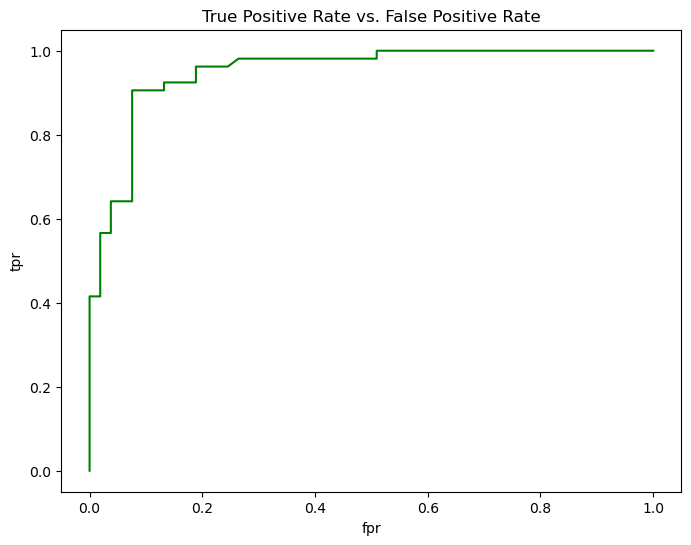

In [67]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='green')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('True Positive Rate vs. False Positive Rate')
plt.show()

### Answer the second question, what are the most important features?

In [59]:
from sklearn.inspection import permutation_importance

importance = permutation_importance(gs, X_test, y_test, n_repeats = 30, random_state = 7)
for i in importance.importances_mean.argsort()[::-1]:
    if importance.importances_mean[i] - 2 * importance.importances_std[i] > 0:
        print(f"   {features.columns[i]:<8}"
              f"   {importance.importances_mean[i]:.3f}"
              f" +/- {importance.importances_std[i]:.3f}")

   RegularMedicine   0.063 +/- 0.018
   Age        0.060 +/- 0.018
   BMI        0.025 +/- 0.011
   SoundSleep   0.025 +/- 0.012
   BPLevel    0.018 +/- 0.008


In [80]:
features.columns[2]

'Age'